In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
class Clean_database:
    def __init__(self, dbase_name="merged.csv"):
        """
        Ładuje bazę danych, następnie czyta za pomocą pandas.read_csv() i tworzy dla niej zmienną globalną "df"
        """
        self.dbase_name = dbase_name
        self.col_list = ['Date','HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR','HST', 'AST', 'HC', 'AC', 'HV', 'AV']
        self.df = pd.read_csv(self.dbase_name)
        self.df = self.df[self.col_list]
        self.df.index.names = ['imatch']
        
    def add_pts(self):
        home_dict = {'H':3, 'D':1, 'A':0}
        away_dict = {'H':0, 'D':1, 'A':3}
        
        self.df["HP"] = self.df['FTR'].map(home_dict)
        self.df["AP"] = self.df['FTR'].map(away_dict)
        
    def season_matchweek(self, season=380, week=10):
        """
        Dodaje indeksy: season, matchweek
        
        season: liczba wszystkich meczów w sezonie
        week: liczba meczów w jednej kolejce
        """
        season = int(season)
        week = int(week)
        div = list(range(int(season/week)))
        
        seasons = list()
        matchweeks = list()
        for i in range(season):
            seasons.append(pd.concat({i:self.df.iloc[i*season:(i+1)*season]}, names=['season']))
            for x in div:
                matchweeks.append(pd.concat({x:(seasons[i][x*week:(x+1)*week])}, names=['matchweek']))
        
        data = pd.concat(matchweeks)
        data = data.reorder_levels(['season','matchweek','imatch']).sort_index()
        
        return data

In [332]:
class Form:
    
    def __init__(self, database, team_names_col='HomeTeam'):
        self.col_names = database.columns
        self.form_df = database.copy()
        self.teams = np.unique(self.form_df[team_names_col])
        self.hfeat = ['HomeTeam','FTHG', 'FTAG','HST','AST','HC','HV','HP']
        self.afeat = ['AwayTeam','FTAG','FTHG','AST','HST','AC','AV','AP']
        
    
    def teams_df(self):
        self.dfs = {}
        for team in self.teams:
            self.dfs[team] = self.form_df[(self.form_df['HomeTeam']==team) | (self.form_df['AwayTeam']==team)]
            
    def home_away(self):
        self.df_ha = {}
        for i,team in enumerate(self.dfs.keys()):
            self.home = self.dfs.get(team)[self.dfs.get(team)['HomeTeam']==team]
            self.home = self.home[self.hfeat]
            self.away = self.dfs.get(team)[self.dfs.get(team)['AwayTeam']==team]
            self.away = self.away[self.afeat]
            self.df_ha[team] = (self.home, self.away)
            
        
    def team_vals(self):
        self.df_vals = {}
        for team in self.df_ha.keys():
            home = self.df_ha.get(team)[0]
            away = self.df_ha.get(team)[1]
            data = pd.concat([home,away]).sort_index()
            data['Team'] = team
            data['Gscored'] = np.where(pd.isnull(data['FTHG']), data['FTAG'], data['FTHG'])
            data['Glost'] = np.where(pd.isnull(data['FTAG']), data['FTHG'], data['FTAG'])
            data['SOT'] = np.where(pd.isnull(data['HST']), data['AST'], data['HST'])
            data['SOTa'] = np.where(pd.isnull(data['AST']), data['HST'], data['AST'])
            data['Corners'] = np.where(pd.isnull(data['HC']), data['AC'], data['HC'])
            data['Points'] = np.where(pd.isnull(data['HP']), data['AP'], data['HP'])
            data['Value'] = np.where(pd.isnull(data['HV']), data['AV'], data['HV'])
            data = data[['Team','Gscored','Glost','SOT','SOTa','Corners','Points','Value']]
            self.df_vals[team] = data
            
    def attack(self, goals_col='Gscored', SOT_col='SOT'):
        '''
        Take column from dataframe, calculate attack atribute and add column
        goals_col: goal scored
        SOT_col = shoots on target
        '''
        
        for team in self.df_vals.keys():
            df = self.df_vals.get(team)
            att = list()
            for g, s in zip(df.loc[:,goals_col], df.loc[:,SOT_col]):
                if s > 0:
                    if (g/s)>1:
                        att.append(1)
                    else:
                        att.append(g/s)
                else:
                    att.append(0)
            df.loc[:,'Attack'] = att
    
    def defence(self, lostG_col='Glost', SOTagst='SOTa'):
        '''
        Take column from dataframe, calculate defence attribute and add column
        lostG-col: goal against
        SOTagst: shoots on target against
        '''
       
    
        for team in self.df_vals.keys():
            df = self.df_vals.get(team)
            att = list()
            for g, s in zip(df.loc[:,lostG_col], df.loc[:,SOTagst]):
                if s > 0:
                    if (g/s)<0:
                        att.append(0)
                    elif (g/s)>1:
                        att.append(1)
                    else:
                        att.append(1-(g/s))
                elif s<=0:
                    att.append(1)
            df.loc[:,'Defence'] = att
    
    def cumulative_pts(self, col='Points'):
        for team in self.df_vals.keys():
            df = self.df_vals.get(team)
            df.loc[:,'CumPts'] = df.groupby(level=0)[col].cumsum()

    def bin_bags(self):
        """
        Dodaje analizę koszykową dla kumulowanej sumy punktów
        """
        self.df_vals = pd.concat(self.df_vals).reset_index(level=0, drop=True).sort_index(level=['imatch'])
        l = len(self.df_vals.groupby(level=1))
        cum = []
        for x in range(len(self.df_vals.groupby(level=0))):
            a = self.df_vals.loc[x]

            for i in range(l):
                data = a.iloc[a.index.get_level_values("matchweek")==i]
                grouping = pd.cut(data['CumPts'], 5, labels=False)
                cum.append(grouping.values)
        cum = np.ravel(cum)
        self.df_vals.loc[:,'Bag'] = cum
        
    def run(self):
        p_dict = {3:1, 1:0, 0:-1}
        self.df_vals.loc[:,'Run'] = self.df_vals['Points'].map(p_dict)
        
    def invals_labels(self, roll=3, goals_split=2.5):
        
        test = self.df_vals.loc[:,['Team','Corners','Value','Attack','Defence','Bag','Run']]
        label = self.df_vals.loc[:,'Gscored'] + self.df_vals.loc[:,'Glost']
        test.loc[:,'U/O'] = [0 if x > goals_split else 1 for x in label]
        
        alls = []
        for i in range(len(test.groupby(level=0))):
            teams = test['Team'].loc[i].unique()
            tms = []
            for team in teams:
                z = test[test['Team']==team].loc[i]
                lista = []
                r = 0
                for x in z['Run']:
                    if x == -1:
                        r = 0
                        lista.append(r)
                    else:
                        r += x
                        lista.append(r)
                z.loc[:,'Run'] = lista
                z.loc[:,['Corners','Attack','Defence']] = \
                z.loc[:,['Corners','Attack','Defence']].rolling(roll).mean().shift(1)
                z.loc[:,['Bag','Run']] = z.loc[:,['Bag','Run']].shift(1)
                tms.append(z)
            data = pd.concat({i:pd.concat(tms)}, names=['season'])
            alls.append(data)
        n = pd.concat(alls)
        n.sort_index(inplace=True)
        
        s = n.index.unique(level=0).tolist()

        cum = []
        for x in s:
            m = n.loc[(x)].index.unique(level=0).tolist()
            for i in m:
                r = n.loc[(x,i)].index.unique().tolist()
                for c in r:
                    data = n.loc[(x,i,c)]
                    if int(len(data)) != 2:
                        print(data)
                    elif ~(data.isnull().values.any()):
                        cum.append(data)
        g = pd.concat(cum)
        
        s = n.index.unique(level=0).tolist()
        
        ftr = []
        labels = []
        cum = []
        for x in s:
            m = g.loc[(x)].index.unique(level=0).tolist()
            for i in m:
                r = g.loc[(x,i)].index.unique().tolist()
                for c in r:
                    data = g.loc[(x,i,c)]
                    labels.append(data['U/O'].iloc[1])
                    test = data.drop(columns=['Team','U/O'])
                    cum.append(np.abs(test.iloc[0] - test.iloc[1]))
        nowa = pd.DataFrame(cum).reset_index(drop=True)
        nowa.loc[:,'label'] = labels
        
        return nowa

In [333]:
class Final(Clean_database, Form):
    """
    Zbiera klasy Clean_database i Form oraz wykonuje wszystkie niezbędne operacje dotyczące załadowania,
    czyszczenia oraz dodania atrybutów do bazy danych.
    """
    def __init__(self):
        clean = Clean_database("merged.csv")
        clean.add_pts()
        self.database = clean.season_matchweek()
        
    def get_atts(self):
        """
        zwracą gotową bazę danych dla każdej drużyny
        """
        data = Form(self.database)
        data.teams_df()
        data.home_away()
        data.team_vals()
        data.attack()
        data.defence()
        data.cumulative_pts()
        data.bin_bags()
        data.run()
        dataframe = data.invals_labels(goals_split=1.5)
        
        return dataframe

In [334]:
a = Final()
df = a.get_atts()

In [335]:
X = df.iloc[:,:6].values
y = df.iloc[:,6].values

In [336]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.2, stratify=y, random_state=1)

 1) Value           0.250035
 2) Attack          0.241125
 3) Defence         0.230214
 4) Corners         0.130960
 5) Run             0.086445
 6) Bag             0.061221


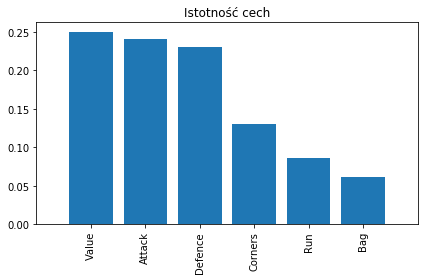

In [337]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 15,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
    
plt.title("Istotność cech")
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [338]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=1,class_weight='balanced'))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Dokładność testu %.3f' % (pipe_lr.score(X_test, y_test)))

Dokładność testu 0.460


#####  interval: 3

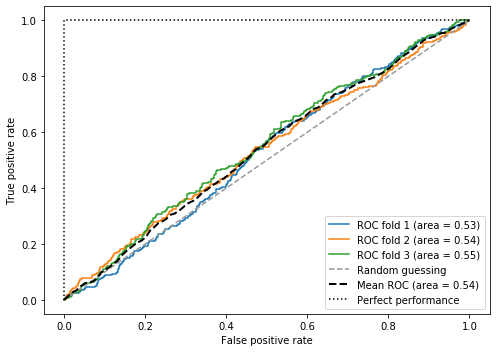

In [339]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version
from sklearn.model_selection import StratifiedKFold


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


X_train2 = X_train
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

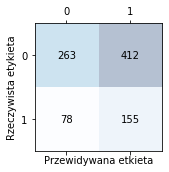

In [340]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Przewidywana etkieta')
plt.ylabel('Rzeczywista etykieta')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [341]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2,
                              random_state=1, class_weight='balanced')

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=-1, 
                        random_state=1,
                       )

In [342]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność agregacji dla danych uczących/testowych %.3f/%.3f'
      % (bag_train, bag_test))

Dokładność drzewa decyzyjnego dla danych uczących/testowych 0.613/0.578
Dokładność agregacji dla danych uczących/testowych 0.564/0.535


In [343]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree =  DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2,
                              random_state=1,
                              class_weight='balanced')

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.01,
                         random_state=1)

In [344]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność algorytmu AdaBoost dla danych uczących/testowych %.3f/%.3f'
      % (ada_train, ada_test))

Dokładność drzewa decyzyjnego dla danych uczących/testowych 0.613/0.578
Dokładność algorytmu AdaBoost dla danych uczących/testowych 0.590/0.515


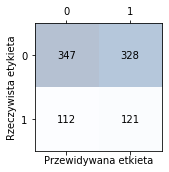

In [345]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Przewidywana etkieta')
plt.ylabel('Rzeczywista etykieta')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

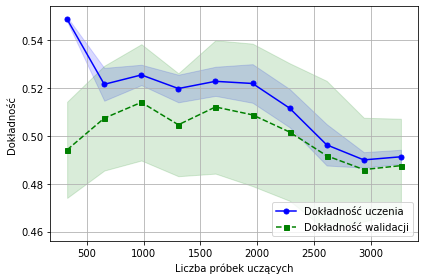

In [346]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000, class_weight='balanced'))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Dokładność uczenia')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Dokładność walidacji')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Liczba próbek uczących')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()